<a href="https://colab.research.google.com/github/dwaipayan05/CovCNN-WebApp/blob/main/COVID_Chest_X_Ray_(ResNet50).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Import Necessary Libraries**

In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
from keras.utils.np_utils import to_categorical
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import  Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import ResNet50
from keras.models import Model, Input
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
%tensorflow_version 2.x
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.4.1
/device:GPU:0
Num GPUs Available:  1


In [ ]:
%cd /content/gdrive/"My Drive"/"COVID Chest X-Ray Analysis"

/content/gdrive/My Drive/COVID Chest X-Ray Analysis


**Fetch Dataset**

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/COVID Chest X-Ray Analysis"
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset
!unzip \*.zip  && rm *.zip

/content/gdrive/My Drive/COVID Chest X-Ray Analysis
sarscov2-ctscan-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sarscov2-ctscan-dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of *.zip or
        *.zip.zip, and cannot find sarscov2-ctscan-dataset.zip.ZIP, period.

No zipfiles found.


**Split Into Train Data & Test Data**

In [ ]:
disease_types=['COVID', 'non-COVID']
data_dir = '/content/gdrive/MyDrive/COVID Chest X-Ray Analysis/Dataset'
train_dir = os.path.join(data_dir)

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])      
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [ ]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print(X_Train.shape)

2481it [00:12, 196.45it/s]


(2481, 64, 64, 3)


In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state = 42)

**Define VGG16 Model Architecture**

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
SIZE=64
N_ch=3

In [ ]:
def build_resnet50():
    resnet50 = ResNet50(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = resnet50(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

**Train the Model**

In [ ]:
model = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('ResNet50_Model.hdf5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=360, 
                        width_shift_range=0.2, 
                        height_shift_range=0.2,
                        zoom_range=0.2, 
                        horizontal_flip=True, 
                        vertical_flip=True) 

datagen.fit(X_train)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 2048)              8192      
_________________________________________________________________
dropout_12 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               5245

In [ ]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
31/31 [==============================] - 9s 138ms/step - loss: 1.3277 - accuracy: 0.4863 - val_loss: 2.8942 - val_accuracy: 0.5191

Epoch 00001: val_loss improved from inf to 2.89421, saving model to ResNet50_Model.hdf5
Epoch 2/100
31/31 [==============================] - 4s 110ms/step - loss: 1.1488 - accuracy: 0.5424 - val_loss: 4.1750 - val_accuracy: 0.5191

Epoch 00002: val_loss did not improve from 2.89421
Epoch 3/100
31/31 [==============================] - 3s 110ms/step - loss: 0.9936 - accuracy: 0.5876 - val_loss: 0.7560 - val_accuracy: 0.4809

Epoch 00003: val_loss improved from 2.89421 to 0.75597, saving model to ResNet50_Model.hdf5
Epoch 4/100
31/31 [==============================] - 4s 112ms/step - loss: 0.8336 - accuracy: 0.6439 - val_loss: 1.1610 - val_accuracy: 0.4809

Epoch 00004: val_loss did not improve from 0.75597
Epoch 5/100
31/31 [==============================] - 3s 111ms/step - loss: 0.8216 - accuracy: 0.6423 - val_loss: 6.6333 - val_accuracy: 0.5191

**Plot the Results**

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

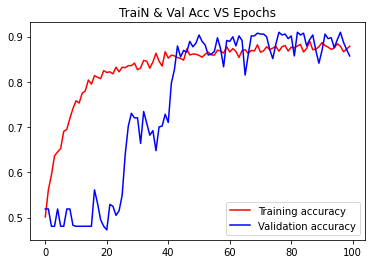

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('TraiN & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

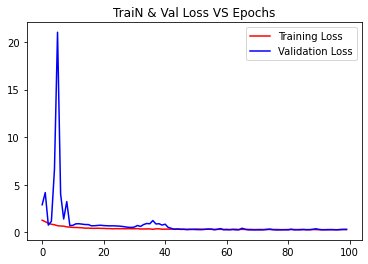

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('TraiN & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
model.load_weights("ResNet50_Model.hdf5")
score = model.evaluate(X_val, Y_val ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

16/16 [==============================] - 0s 23ms/step - loss: 0.2526 - accuracy: 0.9095
Test Loss: 0.2526327967643738
Test accuracy: 90.9456729888916


Text(0.5, 1.0, 'Confusion Matrix')

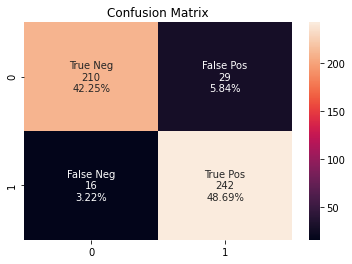

In [ ]:
Y_pred = model.predict(X_val)
Y_predx = np.argmax(Y_pred, axis = -1)
Y_valx = np.argmax(Y_val, axis = -1)
cf_matrix = confusion_matrix(Y_valx, Y_predx)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt = '')
plt.title("Confusion Matrix")